In [1]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt



In [2]:
# prompt: code to unzip file

import zipfile

with zipfile.ZipFile('/content/New_1_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')


In [3]:
# 1. Dataset Preparation
class SEMDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE) / 255.0
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']
        return image, mask.unsqueeze(0)  # Add channel dimension



In [4]:
# Define transformations
transform = A.Compose([
    A.Resize(256, 256),
    A.Rotate(limit=90, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=0.5, std=0.5),
    ToTensorV2(),
], is_check_shapes=False)




In [5]:
# Example dataset (replace with actual paths)
train_mask_paths = [f'/content/TiO2_Masks_TSEM/mask_{i}.tif' for i in range(1,40)]
train_image_paths = [f'/content/TSEM/image_{i}.tif' for i in range(1,40)]
dataset = SEMDataset(train_image_paths, train_mask_paths, transform=transform)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)


In [6]:
# 2. UNet Model Implementation
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(1, 64)
        self.enc2 = self.conv_block(64, 128)
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        d1 = self.up(e2)
        d1 = torch.cat([d1, e1], dim=1)  # Skip connection
        d1 = self.dec1(d1)
        out = self.out(d1)
        return out



In [7]:
# 3. Training the Model
model = UNet()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, dataloader, epochs=20):
    model.train()
    for epoch in range(epochs):
        for images, masks in dataloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")



In [8]:

# Uncomment to train (adjust epochs as needed)
train(model, dataloader)



Epoch 1, Loss: 0.3908044439141223
Epoch 2, Loss: 0.3633518462504273
Epoch 3, Loss: 0.3706449720665559
Epoch 4, Loss: 0.2677872267446067
Epoch 5, Loss: 0.32922587084764626
Epoch 6, Loss: 0.3521280939767419
Epoch 7, Loss: 0.21578081253255732
Epoch 8, Loss: 0.2514718500989754
Epoch 9, Loss: 0.3633596846769049
Epoch 10, Loss: 0.31510622591033804
Epoch 11, Loss: 0.33915547780136673
Epoch 12, Loss: 0.22455054337127775
Epoch 13, Loss: 0.3002505912992446
Epoch 14, Loss: 0.3080575984140018
Epoch 15, Loss: 0.2329169867224184
Epoch 16, Loss: 0.24953991697449338
Epoch 17, Loss: 0.23469774232200688
Epoch 18, Loss: 0.2433787624186206
Epoch 19, Loss: 0.31108101403063065
Epoch 20, Loss: 0.24148069978996467


In [9]:
torch.save(model.state_dict(), 'unet_model_TSEM_images.pth')

In [10]:
# 4. Inference Function
def predict(model, image_path, transform):
    model.eval()
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = transform(image=image)['image'].unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        output = model(image)
    mask = torch.sigmoid(output) > 0.5  # Threshold to binary
    return mask.squeeze().numpy()



In [11]:
# 5. Morphological Analysis
def analyze_mask(mask, pixel_size):
    labeled_mask = label(mask)
    regions = regionprops(labeled_mask)
    equivalent_diameters = [region.equivalent_diameter * pixel_size for region in regions]
    return equivalent_diameters



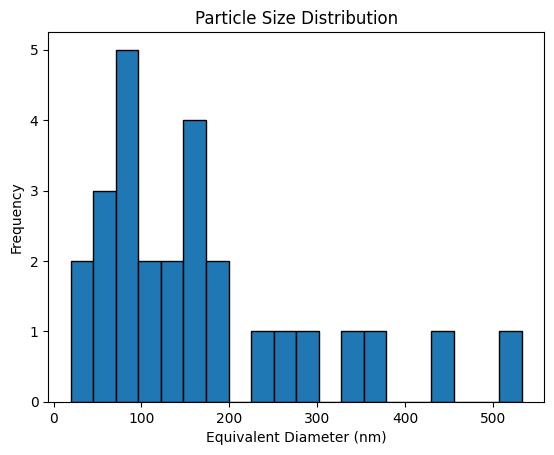

In [12]:
# Example usage
new_image_path = '/content/1908256.tif'  # Replace with actual path
pixel_size = 10  # Adjust based on SEM image scale (e.g., 10 nm/pixel)
model.load_state_dict(torch.load('unet_model_TSEM_images.pth'))  # Load pre-trained model if available
predicted_mask = predict(model, new_image_path, transform)
diameters = analyze_mask(predicted_mask, pixel_size)

# Visualization
plt.hist(diameters, bins=20, edgecolor='black')
plt.xlabel('Equivalent Diameter (nm)')
plt.ylabel('Frequency')
plt.title('Particle Size Distribution')
plt.show()

Particle Size Statistics for LiNiO₂ Cathode Materials:
Mean Diameter: 173.11 nm
Median Diameter: 145.82 nm
Standard Deviation of Diameter: 124.69 nm


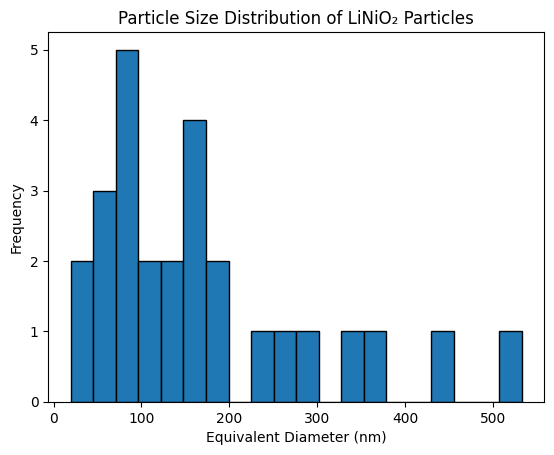

In [13]:
# Compute evaluation metrics
mean_diameter = np.mean(diameters)
median_diameter = np.median(diameters)
std_diameter = np.std(diameters)

# Display results
print(f"Particle Size Statistics for LiNiO₂ Cathode Materials:")
print(f"Mean Diameter: {mean_diameter:.2f} nm")
print(f"Median Diameter: {median_diameter:.2f} nm")
print(f"Standard Deviation of Diameter: {std_diameter:.2f} nm")

# Plot histogram for size distribution
plt.hist(diameters, bins=20, edgecolor='black')
plt.xlabel('Equivalent Diameter (nm)')
plt.ylabel('Frequency')
plt.title('Particle Size Distribution of LiNiO₂ Particles')
plt.show()

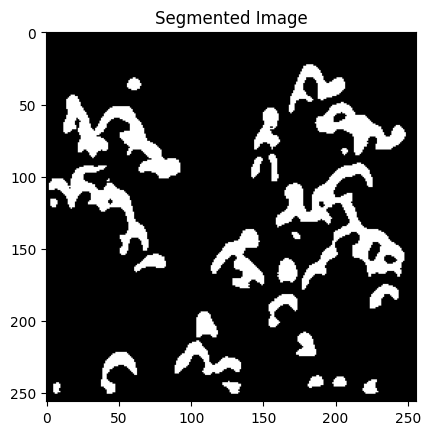

In [14]:

# Show the segmented image
plt.imshow(predicted_mask, cmap='gray')
plt.title('Segmented Image')
plt.show()


In [15]:
# prompt: save the image

# Save the predicted mask as an image
plt.imsave('predicted_mask.png', predicted_mask, cmap='gray')

# Download the saved image
from google.colab import files
files.download('predicted_mask.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>